In [83]:
import pandas as pd
import numpy as np
import copy
import sklearn
import evaluation

## load_data

In [6]:
# load prices
prices = pd.read_csv('/home/eleonorebaelde/KTH/hackathon/lynx/close_prices_insample.csv', index_col='AsOfDate', parse_dates=['AsOfDate'])
ret = prices.diff()

<Axes: xlabel='AsOfDate'>

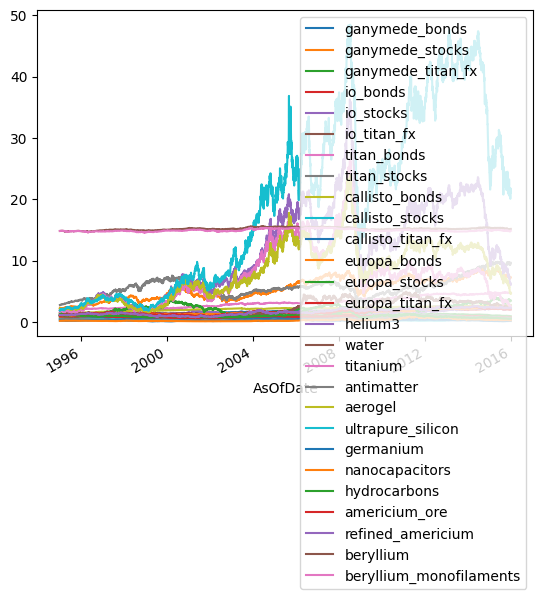

In [7]:
prices.plot()

## enter your own trading strategy here

In [110]:
def trend_model_vectorized_risk_adjusted(ret, trend_window=250, vol_window=100, risk_window=100):
    # calculate vol
    vol = np.sqrt((ret**2).rolling(window=vol_window, min_periods=vol_window//2).sum()) 
    # calculate signal
    sig = np.sign(ret.rolling(window=trend_window).sum())
    # scale with inverse vol to get pos
    pos = sig/vol
    # calculate model risk
    model_risk = (pos.shift(2)*ret).dropna(how='all').sum(axis=1).rolling(risk_window, min_periods=20).std()
    # adjust with model risk
    pos_adjusted = pos.div(model_risk, axis=0)
    return pos_adjusted

position = trend_model_vectorized_risk_adjusted(ret)

## evaluate results

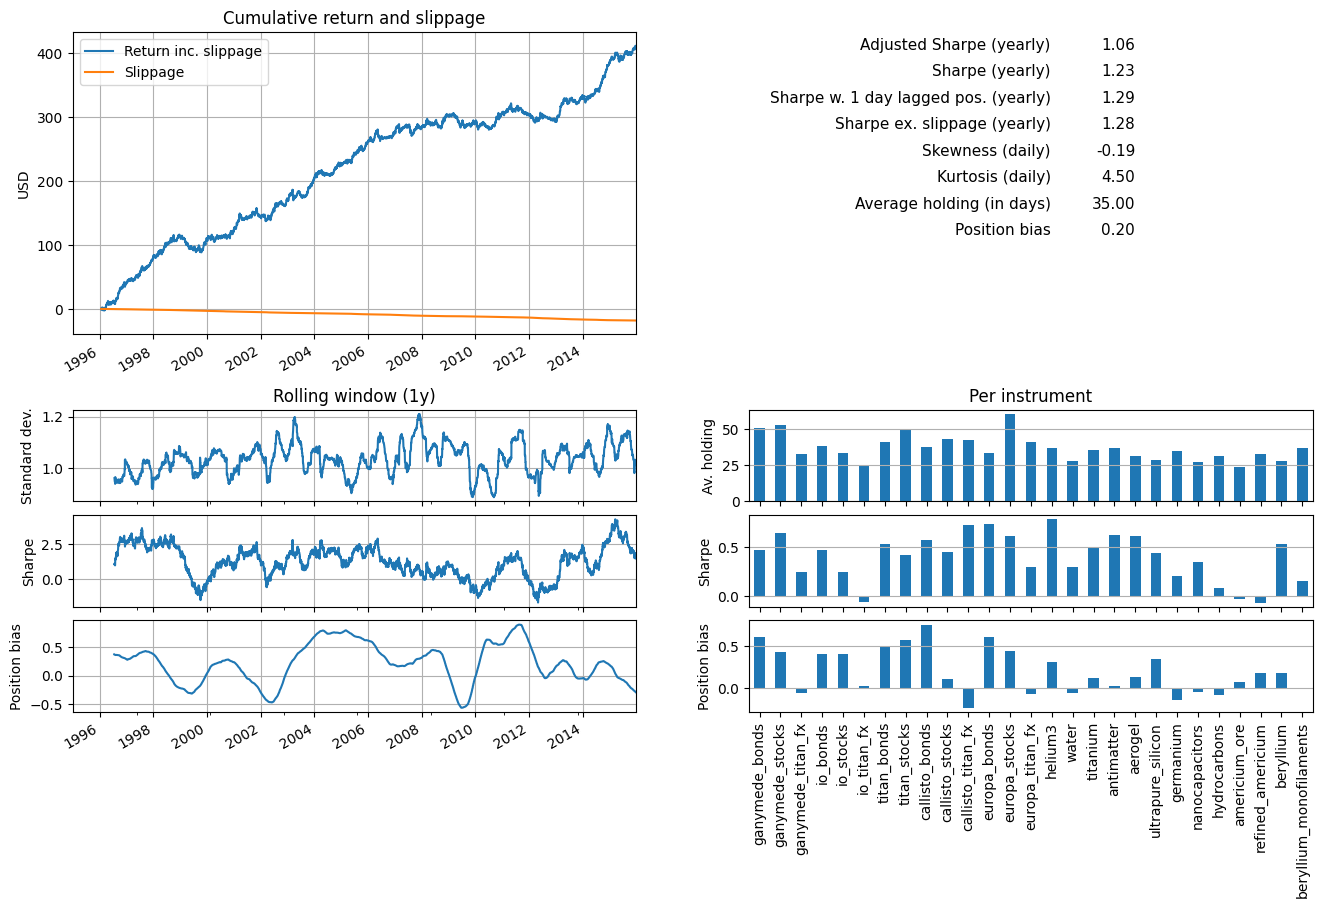

In [111]:
evaluation.plot_key_figures(position, prices)

## Data leakage detection

In [95]:
def data_leakage_detection(prices) :
    # We copy the data
    length = prices.shape[0]
    # We select a random T
    T = np.random.randint(100, length)
    prices_bis = copy.copy(prices)
    values = prices_bis.to_numpy()
    values[T+1:] = values[T+1:] + np.random.randn(length-T-1, prices.shape[1])*2 + 0.1 # We add noise and bias after T to make time series different
    prices_bis = pd.DataFrame(values)
    ret = prices.diff()
    ret_bis = prices_bis.diff()
    position = trend_model_vectorized_risk_adjusted(ret)
    position_bis = trend_model_vectorized_risk_adjusted(ret_bis)
    if (position.iloc[T].to_numpy() != position_bis.iloc[T].to_numpy()).any() :
        return True
    else : 
        return False

leakage = data_leakage_detection(prices)
print("leakage : ", leakage)



leakage :  False


## Train and Validate

In [97]:
import sklearn.model_selection


tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=5)
for i, (train_index, val_index) in enumerate(tscv.split(prices)):
    print(f"Fold {i}:")
    position_train = trend_model_vectorized_risk_adjusted(prices.iloc[train_index])
    figure_train = evaluation.calc_key_figures(position_train, prices.iloc[train_index])
    position_val = trend_model_vectorized_risk_adjusted(prices.iloc[val_index])
    figure_val = evaluation.calc_key_figures(position_val, prices.iloc[val_index])
    print("sharpe train set : ", figure_train["sharpe"], ", sharpe validation set : ", figure_val["sharpe"])
    print("adjusted sharpe train set : ", figure_train["adjusted_sharpe"], ", adjusted sharpe validation set : ", figure_val["adjusted_sharpe"])




Fold 0:
sharpe train set :  0.4761076069508738 , sharpe validation set :  0.7181629540979698
adjusted sharpe train set :  0.4758007281239036 , adjusted sharpe validation set :  0.6850971353413646
Fold 1:
sharpe train set :  0.3184470106184518 , sharpe validation set :  1.6108654891596748
adjusted sharpe train set :  0.31318983012895724 , adjusted sharpe validation set :  0.9118129404060442
Fold 2:
sharpe train set :  0.8936066687842502 , sharpe validation set :  0.08035133936924493
adjusted sharpe train set :  0.819595988258573 , adjusted sharpe validation set :  0.07980033995376966
Fold 3:
sharpe train set :  0.813623986099964 , sharpe validation set :  0.07398653541710795
adjusted sharpe train set :  0.7536064420217583 , adjusted sharpe validation set :  0.07272939321837056
Fold 4:
sharpe train set :  0.7486823387435421 , sharpe validation set :  -0.8946001556917945
adjusted sharpe train set :  0.6752932514735053 , adjusted sharpe validation set :  -0.8510653818023256


## save your positions to a file

In [5]:
position.to_csv('results.csv')